In [21]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.model_selection import GridSearchCV

# Step 1

In this step, I am replacing the numeric values 1 and 0 in the "survived" column with labels yes and no for better readability and interpretation. I am also selecting the numeric columns "age" and "fare" and calculating their mean values. I am filling any missing values in these columns with their respective mean values. For each column in the list of categorical features, I am calculating the mode and replacing missing values with the mode value. I am also converting categorical values in the "sex" and "pclass" columns to numeric values. I am creating a mapping dictionary, where "female" is mapped to 0, "male" is mapped to 1, and "1st," "2nd," and "3rd" classes are mapped to 1, 2, and 3, respectively. All of this is done to preprocess the data.

In [22]:
titanic = pd.read_csv("Titanic.csv")
titanic.head()

Unnamed: 0 pclass  survived                             name     sex  \
0           1    1st         1    Allen, Miss. Elisabeth Walton  female   
1           2    1st         1   Allison, Master. Hudson Trevor    male   
2           3    1st         0     Allison, Miss. Helen Loraine  female   
3           4    1st         0  Allison, Mr. Hudson Joshua Crei    male   
4           5    1st         0  Allison, Mrs. Hudson J C (Bessi  female   

       age  sibsp  parch  ticket        fare    cabin     embarked boat  \
0  29.0000      0      0   24160  211.337494       B5  Southampton    2   
1   0.9167      1      2  113781  151.550003  C22 C26  Southampton   11   
2   2.0000      1      2  113781  151.550003  C22 C26  Southampton  NaN   
3  30.0000      1      2  113781  151.550003  C22 C26  Southampton  NaN   
4  25.0000      1      2  113781  151.550003  C22 C26  Southampton  NaN   

    body                        home.dest  
0    NaN                     St Louis, MO  
1    NaN  Montreal, PQ / Chesterville, ON  
2    NaN  Montreal, PQ / Chesterville, ON  
3  135.0  Montreal, PQ / Chesterville, ON  
4    NaN  Montreal, PQ / Chesterville, ON

In [23]:
titanic['survived'] = titanic['survived'].replace({1: 'yes', 0: 'no'})
# Select numeric columns for which you want to calculate and impute the mean
numeric_columns = ["age", "fare"]

# Calculate the mean for selected numeric columns
mean_values = titanic[numeric_columns].mean()

titanic[numeric_columns] = titanic[numeric_columns].fillna(mean_values)

# Select non-numeric/categorical columns for which you want to fill missing values
categorical_columns = ["name", "sex", "cabin", "embarked", "boat", "body", "home.dest"]

# Fill missing values in categorical columns with the mode
for column in categorical_columns:
    mode_value = titanic[column].mode()[0]  # Calculate the mode
    titanic[column] = titanic[column].fillna(mode_value)
    
titanic['sex'] = titanic['sex'].map( {'female': 0, 'male': 1} ).astype(int)
titanic['pclass'] = titanic['pclass'].map( {'1st': 1, '2nd': 2, '3rd': 3} ).astype(int)

In [24]:
# Split the entire dataset into training and testing sets (80% training, 20% testing)
train_data, test_data = train_test_split(titanic, test_size=0.2, random_state=42)

# Step 2

In this step, I'm fitting a decision tree model using independent values 'pclass', 'sex', 'age', 'sibsp' and dependent variable 'survived'. I am plotting the full decision tree. After plotting the tree, I noticed that tree is using the passenger's sex as the first splitting criterion. This suggests that sex is a strong predictor of survival, with women being more likely to survive than men. The tree is using the passenger's class as a splitting criterion. This suggests that class is also a predictor of survival. It is also using the passenger's age as a splitting criterion, which suggests that age is also an important predictor of survival. These three are the strongest splitting criteria, which makes them the strongest predictors. The tree is also using other features, such as the passenger's age and fare, to make more fine-grained predictions about survival. 

In [25]:
#split dataset in features and target variable
feature_cols = ['pclass', 'sex', 'age', 'sibsp']
X_train = train_data[feature_cols] # Features
y_train = train_data.survived # Target variable

In [26]:
# Create decision tree classifer object
clf = DecisionTreeClassifier()

# Train decision tree Classifer
clf = clf.fit(X_train,y_train)

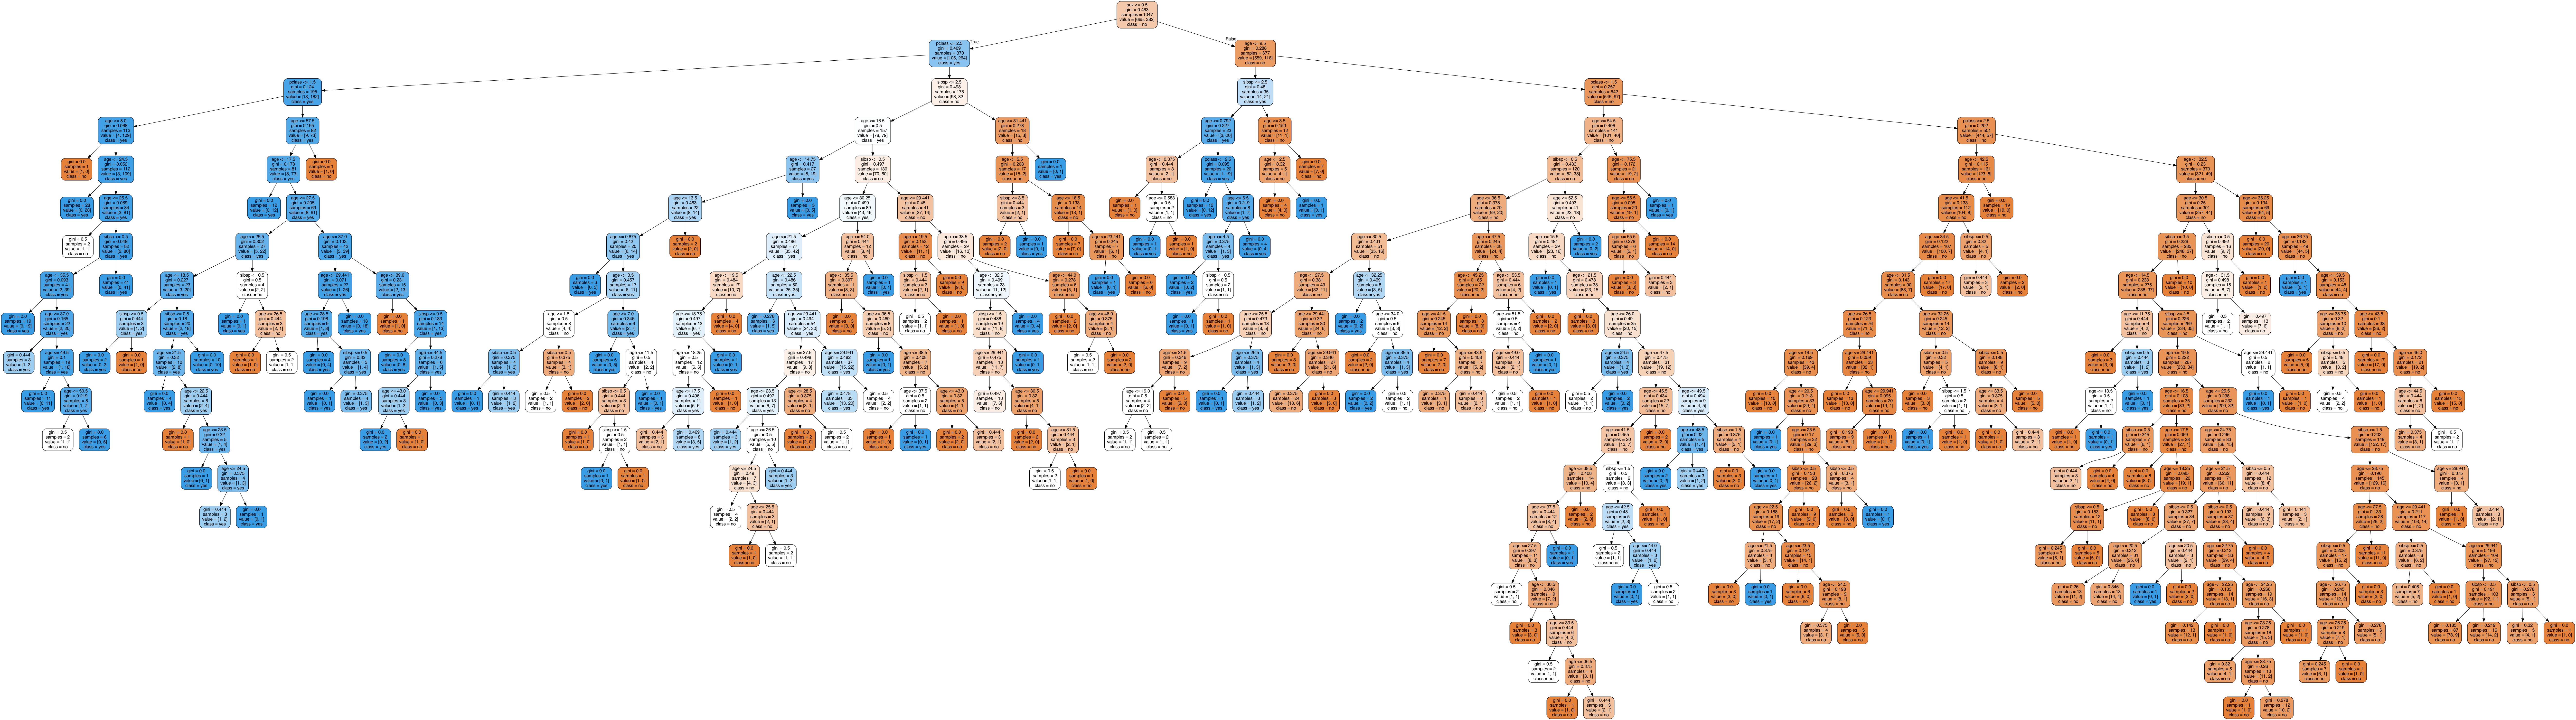

In [27]:
dot_data = export_graphviz(clf, out_file=None, feature_names=feature_cols, class_names=clf.classes_, filled=True, rounded=True)

# Visualize the decision tree using graphviz
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Step 3

In this step, I am using GridSearchCV to find the best parameter max_leaf_nodes to prune the tree and plotting the pruned tree. After using GridSearchCV to optimize the max_leaf_nodes hyperparameter, it suggested that the optimal value for this hyperparameter is 14 leaf nodes. This greatly reduces the complexity of the tree and helps prevent it from growing excessively and overfitting the training data. The pruning process has removed branches and subtrees that do not contribute to the trees predictive accuracy and from the tree and we can easily deduce which passengers were more likely to survive and which passengers are less likely to survive. Pruning the tree has made it so that it's complex enough to predict the overall pattern, while also allowing for predictive accuracy. In conclusion the optimal max_leaf_node hyper parameter is 14.

DecisionTreeClassifier(max_leaf_nodes=14, random_state=42)


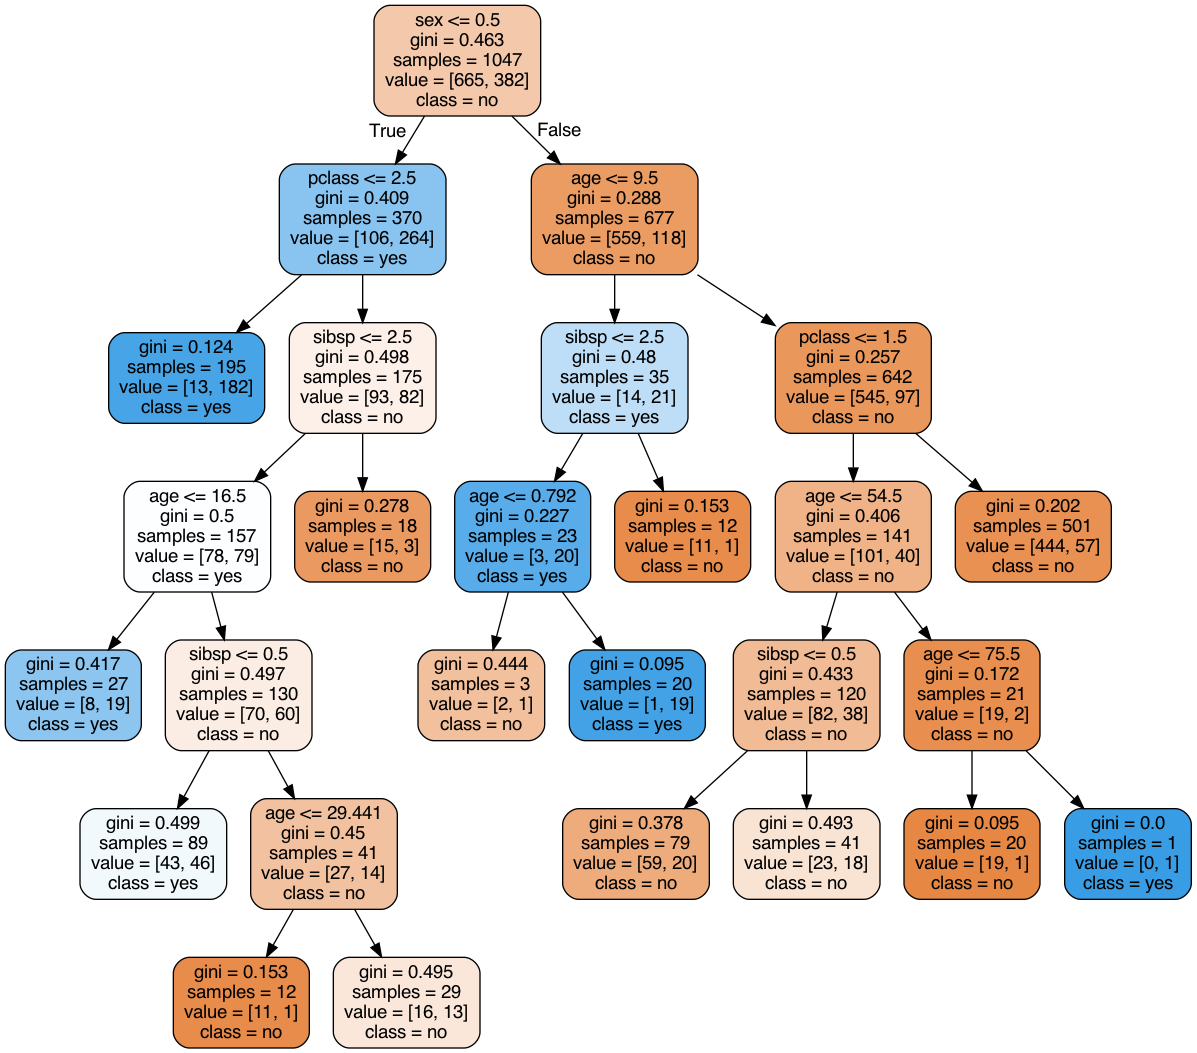

In [28]:
# Define the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_leaf_nodes': range(2, 20)
}

# Create a GridSearchCV 
grid_search = GridSearchCV(clf, param_grid, cv=5,)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

# Get the best estimator (pruned Decision Tree)
best_clf = grid_search.best_estimator_

# Plot the pruned Decision Tree
dot_data = export_graphviz(best_clf, out_file=None, feature_names=feature_cols, class_names=best_clf.classes_, filled=True, rounded=True)
pruned_tree = pydotplus.graph_from_dot_data(dot_data)
Image(pruned_tree.create_png())

# Step 4

In [29]:
# Use the pruned Decision Tree to make predictions on the test set
X_test = test_data[feature_cols]
y_test = test_data.survived
y_pred = best_clf.predict(X_test)

# Calculate the accuracy for survivors and fatalities
num_survivors = sum(y_test == 'yes')
num_fatalities = sum(y_test == 'no')

correct_survivors = sum((y_test == 'yes') & (y_pred == 'yes'))
correct_fatalities = sum((y_test == 'no') & (y_pred == 'no'))

accuracy_survivors = correct_survivors / num_survivors
accuracy_fatalities = correct_fatalities / num_fatalities

print(f"Percent survivors correctly predicted by Pruned Decision Tree: {accuracy_survivors * 100:.2f}%")
print(f"Percent fatalities correctly predicted by Pruned Decision Tree: {accuracy_fatalities * 100:.2f}%")

Percent survivors correctly predicted by Pruned Decision Tree: 59.32%
Percent fatalities correctly predicted by Pruned Decision Tree: 88.89%


# Step 5

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest Classifier with n_estimators = 50 and max_leaf_nodes from the pruned tree
rf_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=best_clf.max_leaf_nodes, n_jobs=-1)

# Fit the Random Forest model on the training data
rf_clf.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
rf_y_pred = rf_clf.predict(X_test)

# Calculate the accuracy for survivors and fatalities
rf_correct_survivors = sum((y_test == 'yes') & (rf_y_pred == 'yes'))
rf_correct_fatalities = sum((y_test == 'no') & (rf_y_pred == 'no'))

rf_accuracy_survivors = rf_correct_survivors / num_survivors
rf_accuracy_fatalities = rf_correct_fatalities / num_fatalities

print(f"Percent survivors correctly predicted by Random Forest: {rf_accuracy_survivors * 100:.2f}%")
print(f"Percent fatalities correctly predicted by Random Forest: {rf_accuracy_fatalities * 100:.2f}%")

Percent survivors correctly predicted by Random Forest: 59.32%
Percent fatalities correctly predicted by Random Forest: 90.28%


Both the decision tree classifier and the random forest classifier were similarly accurate. Both of them correctly predicted 57-60% survivors correctly and 88-90% of fatalities correctly. Both classifiers were more accurate in predicting fatalities than survivors. There may be several reasons why this is the case. It may be the case that there is feature imbalance for this data. Perhaps features in this dataset are more informative or discriminatory for predicting fatalities than survivors. Perhaps, we also need more samples to learn from in order to predict survivors more accurately. Perhaps, it has to do with the data distribution. Maybe the dataset's distribution is skewed in a way that makes it more difficult to predict survivors than fatalities. There is also the matter of decision trees overfitting. Decision trees have the tendency to overfit the data which means they may perform well on training data, but poorly on testing data. Also the data set may be too small for the random forest classifier to perform well. Random forest classifiers perform better on large datasets in order to make use of the ensemble nature of the random forest. If the dataset is small, the random forest may not offer a significant advantage over the decision tree in terms of predictive accuracy.